# Lab09 Report

## st122314

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

['data/names/French.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Japanese.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Czech.txt', 'data/names/Irish.txt', 'data/names/Greek.txt', 'data/names/Korean.txt', 'data/names/Vietnamese.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/Arabic.txt', 'data/names/Dutch.txt', 'data/names/Italian.txt']


In [2]:
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

Slusarski


In [3]:
# Build the category_lines dictionary, a list of names per language

category_lines = {}
all_categories = []

# Read a file and split into lines

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# Check that it worked

for c in all_categories[:2]:
    print(c)
    print(category_lines[c]) 

French
['Abel', 'Abraham', 'Adam', 'Albert', 'Allard', 'Archambault', 'Armistead', 'Arthur', 'Augustin', 'Babineaux', 'Baudin', 'Beauchene', 'Beaulieu', 'Beaumont', 'Belanger', 'Bellamy', 'Bellerose', 'Belrose', 'Berger', 'Beringer', 'Bernard', 'Bertrand', 'Bisset', 'Bissette', 'Blaise', 'Blanc', 'Blanchet', 'Blanchett', 'Bonfils', 'Bonheur', 'Bonhomme', 'Bonnaire', 'Bonnay', 'Bonner', 'Bonnet', 'Borde', 'Bordelon', 'Bouchard', 'Boucher', 'Brisbois', 'Brodeur', 'Bureau', 'Caron', 'Cavey', 'Chaput', 'Charbonneau', 'Charpentier', 'Charron', 'Chastain', 'Chevalier', 'Chevrolet', 'Cloutier', 'Colbert', 'Comtois', 'Cornett', 'Cote', 'Coupe', 'Courtemanche', 'Cousineau', 'Couture', 'Daniau', "D'aramitz", 'Daviau', 'David', 'Deforest', 'Degarmo', 'Delacroix', 'De la fontaine', 'Deniau', 'Deniaud', 'Deniel', 'Denis', 'De sauveterre', 'Deschamps', 'Descoteaux', 'Desjardins', 'Desrochers', 'Desrosiers', 'Dubois', 'Duchamps', 'Dufort', 'Dufour', 'Duguay', 'Dupond', 'Dupont', 'Durand', 'Durant', '

In [4]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [5]:
# One-hot encoding of a word vocabulary using scikit-learn’s OneHotEncoder

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)
print(encoder.fit_transform([['red'], ['green'], ['blue']]))

# One-hot encoding of a word using numpy

import numpy as np

arr = [2, 1, 0]
max = np.max(arr) + 1
print(np.eye(max)[arr])

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [6]:
import torch

# Find letter index from all_letters, e.g. "a" -> 0

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# The RNN

In [7]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [8]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)
output

tensor([[-2.9221, -2.8667, -2.9440, -2.9279, -2.9974, -2.7915, -2.8015, -2.9156,
         -2.8073, -2.8841, -3.0149, -2.9314, -2.9539, -2.8133, -2.8930, -2.8462,
         -2.8499, -2.9025]], grad_fn=<LogSoftmaxBackward0>)

In [9]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

next_hidden = hidden
for i in range(input.shape[0]):
    output, next_hidden = rnn(input[i], next_hidden)
    print(output)

tensor([[-2.9221, -2.8667, -2.9440, -2.9279, -2.9974, -2.7915, -2.8015, -2.9156,
         -2.8073, -2.8841, -3.0149, -2.9314, -2.9539, -2.8133, -2.8930, -2.8462,
         -2.8499, -2.9025]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.8566, -3.0259, -2.9264, -2.9519, -2.9932, -2.8795, -2.8142, -2.9693,
         -2.9083, -2.8637, -2.9488, -2.8146, -2.9170, -2.8762, -2.9235, -2.8599,
         -2.7312, -2.8126]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9280, -2.9790, -2.9515, -2.7960, -2.9839, -2.7828, -2.7685, -3.0659,
         -2.8904, -2.8941, -2.9057, -2.8776, -2.9043, -2.9171, -2.9550, -2.9407,
         -2.7395, -2.8095]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9031, -2.9485, -2.8484, -2.8379, -2.9047, -2.8357, -2.8272, -2.9306,
         -2.7791, -2.8567, -3.0414, -2.9693, -2.9370, -2.9176, -2.9623, -2.9015,
         -2.7906, -2.8738]], grad_fn=<LogSoftmaxBackward0>)
tensor([[-2.9160, -2.9032, -2.9298, -2.8983, -2.8618, -2.9117, -2.8022, -2.9138,
         -2.8340, -2.8305, -2.9

# Training

In [10]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Scottish', 6)


In [11]:
#add a function to get a random element of our training set:

import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Gomez
category = Italian / line = Cipriani
category = Italian / line = Gimondi
category = Portuguese / line = Souza
category = Irish / line = John
category = Japanese / line = Takano
category = Dutch / line = Specht
category = German / line = Garber
category = Scottish / line = Smith
category = Scottish / line = Ross


In [12]:
# For the loss function, let's use negative log likelihood:
criterion = nn.NLLLoss() 

In [13]:
#Then a function for training on one sequence:

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(- learning_rate * p.grad.data)

    return output, loss.item() 

In [14]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 18s) 2.8338 Baudin / Scottish ✗ (French)
10000 10% (0m 37s) 2.2187 Callaghan / Russian ✗ (Irish)
15000 15% (0m 55s) 1.0459 Aswad / Arabic ✓
20000 20% (1m 14s) 2.9444 Bishara / Japanese ✗ (Arabic)
25000 25% (1m 32s) 1.5259 Etxeberria / Greek ✗ (Spanish)
30000 30% (1m 51s) 1.0112 Ta / Vietnamese ✓
35000 35% (2m 10s) 0.0344 Rutkowski / Polish ✓
40000 40% (2m 28s) 2.6032 Tombs / Arabic ✗ (English)
45000 45% (2m 47s) 0.9723 Basurto / Portuguese ✓
50000 50% (3m 6s) 2.6317 Cruz / Spanish ✗ (Portuguese)
55000 55% (3m 24s) 1.9146 Bracey / Czech ✗ (English)
60000 60% (3m 42s) 0.1084 Slusarczyk / Polish ✓
65000 65% (4m 0s) 0.0461 Kowalczyk / Polish ✓
70000 70% (4m 18s) 0.3912 Zabek / Polish ✓
75000 75% (4m 36s) 2.4012 Masson / Scottish ✗ (French)
80000 80% (4m 54s) 0.8807 Maille / Irish ✓
85000 85% (5m 12s) 0.9417 Onoda / Japanese ✓
90000 90% (5m 29s) 0.8131 Wagner / German ✓
95000 95% (5m 48s) 2.1222 Santana / Spanish ✗ (Portuguese)
100000 100% (6m 6s) 2.2920 Grabski / Polish ✗ (Czec

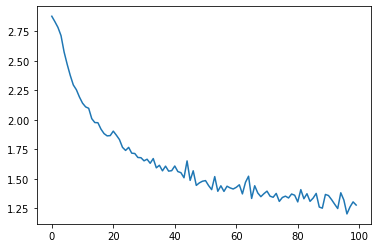

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [16]:
all_losses[-1]

1.2768991044315625

# Evaluation

/tmp/ipykernel_22615/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_22615/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


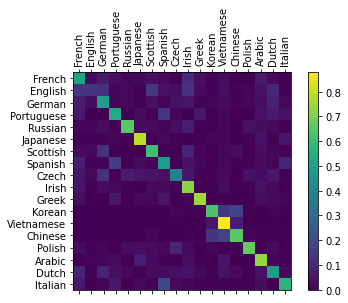

In [17]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

# Prediction user input

In [18]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Ivy')
predict('Phyo')
predict('Kaung')


> Ivy
(-0.77) Czech
(-2.00) English
(-2.43) Irish

> Phyo
(-0.75) Vietnamese
(-1.96) Korean
(-2.11) Japanese

> Kaung
(-1.49) Chinese
(-1.63) Japanese
(-1.64) German


##### In this report, I made three parts for indepandent works which are the following.

##### 1. Change the structure to be identical to Goodfellow's Figure 10.3 (no input-to-hidden connection) with tanh activation functions and see if you get different results.

##### 2. Explore methods for batching patterns of different length prior to presentation to a RNN and implement them. See how much speedup you can get from the GPU with minibatch training.

##### 3. Do a bit of research on similar problems such as named entity recognition, find a dataset, train a model, and report your results.

# Part1

### 1. Change the structure to be identical to Goodfellow's Figure 10.3 (no input-to-hidden connection) with tanh activation functions and see if you get different results.

In [19]:
import torch.nn as nn

class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ElmanRNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        hidden = self.tanh(hidden)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
elman_rnn = ElmanRNN(n_letters, n_hidden, n_categories)

In [20]:
print(n_letters)

57


#### I employed the Tanh activation layer without input-to-hidden skip connection and the following is the modified the Elman RNN architecture.

In [21]:
elman_rnn

ElmanRNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
  (tanh): Tanh()
)

In [22]:
def train_Elman_RNN(rnn,category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(- learning_rate * p.grad.data)

    return output, loss.item()

In [23]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

# def timeSince(since):
#     now = time.time()
#     s = now - since
#     m = math.floor(s / 60)
#     s -= m * 60
#     return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train_Elman_RNN(elman_rnn, category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 21s) 2.6220 Tieu / Chinese ✗ (Vietnamese)
10000 10% (0m 49s) 1.5681 Chi / Chinese ✗ (Korean)
15000 15% (1m 20s) 1.4433 Cloutier / French ✓
20000 20% (1m 47s) 1.1147 Sugimura / Japanese ✓
25000 25% (2m 14s) 3.5685 Donk / Korean ✗ (Dutch)
30000 30% (2m 41s) 0.0752 Neroni / Italian ✓
35000 35% (3m 8s) 1.4031 Courtemanche / French ✓
40000 40% (3m 35s) 0.1954 Brzezicki / Polish ✓
45000 45% (4m 1s) 0.6040 Slazak / Polish ✓
50000 50% (4m 23s) 1.1071 Uchida / Japanese ✓
55000 55% (4m 45s) 0.6956 Romijnsen / Dutch ✓
60000 60% (5m 7s) 0.6070 Bell / Scottish ✓
65000 65% (5m 28s) 3.0695 Kabisha / Japanese ✗ (Russian)
70000 70% (5m 49s) 2.8030 Albuquerque / French ✗ (Portuguese)
75000 75% (6m 10s) 0.2427 Filipek / Polish ✓
80000 80% (6m 31s) 0.2206 Foong / Chinese ✓
85000 85% (6m 51s) 2.9140 Villeneuve / English ✗ (French)
90000 90% (7m 14s) 1.0633 Grosser / German ✓
95000 95% (7m 38s) 0.6649 Chino / Japanese ✓
100000 100% (8m 3s) 1.4134 Flater / Czech ✗ (German)


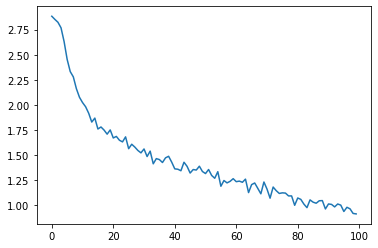

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [25]:
all_losses[-1]

0.914560677053174

#### I got lower losses with the Elman network than using than the simple RNN (1.2768991044315625[simple RNN] vs 0.914560677053174[Elman RNN]). But the training time is also increased (6m 6s[simple RNN] vs 8m 3s[Elman RNN]).

# Task 2

### 2. Explore methods for batching patterns of different length prior to presentation to a RNN and implement them. See how much speedup you can get from the GPU with minibatch training.

##### - batched_lines function will pad all the word with all zero array after each word until the size of that word is equal to the biggest size in the list. Then pack those words into tensor.

##### - batched_categories function is transform tags into tensor.

In [26]:
# https://www.marktechpost.com/2020/04/12/implementing-batching-for-seq2seq-models-in-pytorch/
def batched_lines(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

def batched_categories(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

##### For the batching, I implemented to get an array of K random samples from the dataset

In [27]:
def randomTrainingBatch(K):
    if(K == 1):
        category = randomChoice(all_categories)
        line = randomChoice(category_lines[category])
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line)
        return category, line, category_tensor, line_tensor
    else:
        max_length = 0
        categories = []
        lines = []
        lines_length = []
        for i in range(K):
            category = randomChoice(all_categories)
            line = randomChoice(category_lines[category])
            categories.append(category)
            lines.append(line)
            lines_length.append(len(line))
            if(len(line) > max_length): max_length = len(line)
        line_tensor = batched_lines(lines,max_length)
        category_tensor = batched_categories(categories)
        return categories, lines, category_tensor, line_tensor

In [29]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size = 1):
        return torch.zeros(batch_size, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
    
 


In [30]:
criterion = nn.NLLLoss()

In [31]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(line_tensor.shape[1])

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(- learning_rate * p.grad.data)

    return output, loss.item()  

In [32]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()


for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingBatch(10) 
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))


    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 20s) 2.8851 ['Asis', 'Nicolson', 'Mata', 'Ly', 'Adsit', 'Fabian', 'Bitar', "O'Sullivan", 'Bernat', 'Pugliese'] / Czech ✗ (['Spanish', 'English', 'Portuguese', 'Vietnamese', 'Czech', 'Polish', 'Arabic', 'Irish', 'German', 'Italian'])
10000 10% (0m 41s) 2.8374 ['Henderson', 'Kowalczyk', 'Laren', 'Van', 'Campos', 'Bakis', 'Flann', 'Rutten', 'Bao', 'Breiner'] / Greek ✗ (['Scottish', 'Polish', 'Dutch', 'Vietnamese', 'Portuguese', 'Russian', 'Irish', 'Dutch', 'Chinese', 'German'])
15000 15% (1m 2s) 2.3693 ['Beringer', 'Walker', 'Pawlitzki', 'Prieto', 'Valerio', 'Emile', 'Mo', 'Peeters', 'Krytinar', 'Kassis'] / German ✗ (['French', 'Scottish', 'German', 'Spanish', 'Italian', 'French', 'Korean', 'Dutch', 'Czech', 'Arabic'])
20000 20% (1m 23s) 2.0906 ['Charron', 'Severijns', 'Hooton', 'Hong', 'Harrison', 'Sala', 'Toomer', 'Kawai', 'Haber', 'Hong'] / Irish ✗ (['French', 'Dutch', 'English', 'Chinese', 'English', 'Spanish', 'English', 'Japanese', 'German', 'Chinese'])
25000 25% (1m 43s

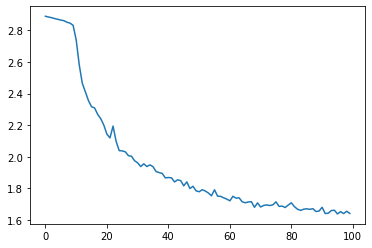

In [33]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

#### With minibatch training , it takes faster time than without batching and only 6m 56s.

# Task 3

### 3. Do a bit of research on similar problems such as named entity recognition, find a dataset, train a model, and report your results.

##### For the named entity recognization dataset, I downloaded from https://www.kaggle.com/datasets/namanj27/ner-dataset.

In [34]:
import pandas as pd
data = pd.read_csv('ner_dataset.csv', encoding= 'unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [35]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        # A bit more efficient than normal Softmax
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # print(input.shape, hidden.shape)
        combined = torch.cat((input, hidden), 1)
        a = self.i2h(combined)
        hidden = torch.tanh(a)
        o = self.h2o(hidden)
        y_hat = self.softmax(o)
        # hidden = self.i2h(combined)
        # output = self.i2o(combined)
        # output = self.softmax(output)
        return y_hat, hidden

    def initHidden(self, batch_size = 1):
        return torch.zeros(batch_size, self.hidden_size)

In [36]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch

# Util Functions
def findFiles(path):
    return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def letterToIndex(letter):
    return all_letters.find(letter)

# (For demonstration) turn a letter into a <1 x n_letters> tensor

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters> tensor
# (an array of one-hot letter vectors)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i




# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]


# Prepare Data
all_letters = string.ascii_letters + " .,;'"

category_lines = {}
all_categories = []

n_letters = len(all_letters)

for pos in list(set(data['POS'].to_list())):
    category_lines[pos] = []
    all_categories.append(pos)

for word,pos in zip(data['Word'].to_list(),data['POS'].to_list()):
    category_lines[pos].append(word)


# for filename in findFiles('data/names/*.txt'):
#     category = os.path.splitext(os.path.basename(filename))[0]
#     all_categories.append(category)
#     lines = readLines(filename)
#     category_lines[category] = lines


n_categories = len(all_categories)

In [37]:
# https://www.marktechpost.com/2020/04/12/implementing-batching-for-seq2seq-models-in-pytorch/
def batched_lines(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

def print_char(name_reps):
    # name_reps = name_reps.view((-1, name_reps.size()[-1]))
    # print(name_reps)
    for t in name_reps: 
        # if torch.sum(t) == 0:
        #     print('')
        # else:
            index = t.argmax()
            print(all_letters[index])

def batched_categories(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = all_categories.index(lang)
    return rep

In [38]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


import random

def randomChoice(l):
    # random.randint range is inclusive thus len(l)-1
    return l[random.randint(0, len(l) - 1)]

def randomTrainingBatch(batch_size = 1):
    if(batch_size == 1):
        category = randomChoice(all_categories)
        line = randomChoice(category_lines[category])
        category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
        line_tensor = lineToTensor(line)
        return category, line, category_tensor, line_tensor
    else:
        max_length = 0
        categories = []
        lines = []
        lines_length = []
        for i in range(batch_size):
            category = randomChoice(all_categories)
            line = randomChoice(category_lines[category])
            categories.append(category)
            lines.append(line)
            lines_length.append(len(line))
            if(len(line) > max_length): max_length = len(line)
        line_tensor = batched_lines(lines,max_length)
        category_tensor = batched_categories(categories)
        # padded_line_tensor = torch.nn.utils.rnn.pack_padded_sequence(line_tensor, lines_length, enforce_sorted = False)
        return categories, lines, category_tensor, line_tensor

# for i in range(10):
# category, line, category_tensor, line_tensor = randomTrainingExample(10)
# print(category_tensor.shape, line_tensor.shape)
#     print('category =', category, '/ line =', line)

# If use softmax -> corss entropy
# If use logsoftmax -> negative log likelihood loss
criterion = nn.NLLLoss()

In [39]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden(line_tensor.shape[1])

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [40]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()


batch_size = 10
# n_iters = int(n_iters / batch_size)
# print_every = int(print_every / batch_size)
# plot_every = int(plot_every / batch_size)

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingBatch(batch_size)
    # print(type(category_tensor.to('cuda:1')), type(line_tensor))

    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

/tmp/ipykernel_22615/580995838.py:16: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  p.data.add_(-learning_rate, p.grad.data)


5000 5% (0m 19s) 3.7277 ['positive', 'most', 'Three', 'two', ')', '$', 'where', 'He', 'to', 'further'] / JJR ✗ (['JJ', 'RBS', 'CD', 'CD', 'RRB', '$', 'WRB', 'PRP', 'TO', 'JJ'])
10000 10% (0m 39s) 3.2571 ['pleading', 'earlier', '5', 'more', 'is', 'continue', ')', 'most', 'such', ')'] / VBG ✗ (['VBG', 'JJR', 'CD', 'JJR', 'VBZ', 'VB', 'RRB', 'RBS', 'PDT', 'RRB'])
15000 15% (0m 58s) 2.5040 ['who', '$', 'which', 'can', 'Muslims', 'Monday', ';', 'will', 'his', 'such'] / WP ✗ (['WP', '$', 'WDT', 'MD', 'NNPS', 'NNP', ';', 'MD', 'PRP$', 'PDT'])
20000 20% (1m 17s) 2.1616 ['well', '(', 'earlier', ')', 'Ah', 'that', 'that', 'to', 'their', ')'] / NNPS ✗ (['RB', 'LRB', 'RBR', 'RRB', 'UH', 'WDT', 'WDT', 'TO', 'PRP$', 'RRB'])
25000 25% (1m 36s) 1.8256 ['"', '(', 'are', 'earlier', 'intense', 'and', 'all', '$', 'more', 'will'] / $ ✗ (['``', 'LRB', 'VBP', 'JJR', 'JJ', 'CC', 'PDT', '$', 'RBR', 'MD'])
30000 30% (1m 54s) 1.8286 ['would', 'Hunters', ']', 'most', 'Kurds', 'is', "'s", 'distribute', 'groups', '

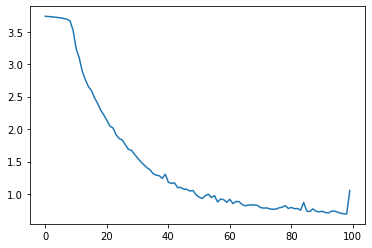

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

/tmp/ipykernel_22615/3585656379.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
/tmp/ipykernel_22615/3585656379.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


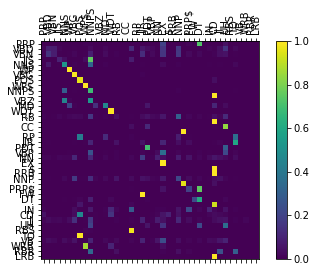

In [43]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [46]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('rain')
predict('raining')
predict('rained')
predict('rains')



> rain
(-1.47) JJ
(-1.80) NNP
(-2.44) UH

> raining
(-0.04) VBG
(-4.67) JJ
(-4.73) NNP

> rained
(-1.49) NNP
(-1.81) JJ
(-2.20) VBN

> rains
(-0.53) NNPS
(-1.38) NNS
(-3.63) PRP$
